<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/wpca_white_noise_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wpca

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.0/901.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wpca: filename=wpca-0.1-py3-none-any.whl size=11661 sha256=d9909e63fc65eebeb986858f85628471af8931406b31282779197519147a9aa0
  Stored in directory: /root/.cache/pip/wheels/e8/ad/cc/747227c4f8a2a1da6ed15643a001308952f59b67c21e299c29
Successfully built wpca


In [3]:
# @title Import packages

#import cupy as np
#from cupyx.scipy.special import erf

import numpy as np
import matplotlib.pyplot as plt
import imageio
import gc
import os
import time
from scipy.special import erf

from sklearn.decomposition import PCA
from wpca import EMPCA, WPCA

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')
folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise'
os.chdir(folder_path)

Mounted at /content/gdrive/


## GPU White Noise Sampling

In [5]:
def gaussian_to_exp(grf,lamb):
    grf_mean = np.mean(grf)
    grf_std_dev = np.std(grf)
    xu = 0.5 * (1 + erf((grf - grf_mean) / (np.sqrt(2) * grf_std_dev)))

    exprf = -1/lamb  * np.log(1 - xu)
    return exprf

In [8]:

wpca_vec_list = []
wpca_ev_list = []

threshold = 0
l= 9
bl = 2*l +1

target = 10000

start = time.time()

for _ in range(target):

    white_noise = np.random.normal(loc=0, scale = 1, size=[bl,bl,bl] ) # sampling guassian white noise
    exprf = gaussian_to_exp(white_noise, 1) # convert to exponential white noise

    coords = np.where( exprf > threshold) # obtain the coordinates of all points
    amps, coords = exprf[coords], np.array(coords).T # obtain the amplitudes for each coordinates (1-1 mapping), and the set of coordinates
    amps = amps/np.sum(amps) #Normalized amplitudes
    #coord_amp = np.array( [(coord[0],coord[1],coord[2], amp ) for coord, amp in zip(coords, amps)]) #Normalized amplitudes. Threshold = 0, Max Pt. = 1.
    weights = np.zeros_like(coords, dtype=np.float64)

    for nn in range(amps.shape[0]):
        weights[nn] = np.array( [amps[nn], amps[nn], amps[nn]] )
    #       weights[nn] = np.array( [coord_amp[nn][3],coord_amp[nn][3],coord_amp[nn][3]])

    wpca = WPCA(n_components=3)
    wpca.fit(X = coords, weights=weights)

    wpca_vec_list.append(wpca.components_)
    wpca_ev_list.append(wpca.explained_variance_ratio_)

print('Simulation time =', int(time.time()- start))

Simulation time = 10


In [ ]:
# @title Save results

working_directory=  f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/wpca_white_noise/l_{l}'

if not os.path.exists(working_directory):
    os.makedirs(working_directory)
    print(f"Directory created for l={l}")

os.chdir(working_directory)
os.getcwd()

import random
id = random.randint(0,65535)

np.save(f'wpca_white_noise_id_{id}_l_{l}_vec.npy', wpca_vec_list)
np.save(f'wpca_white_noise_id_{id}_l_{l}_ev.npy', wpca_ev_list)

## Plots

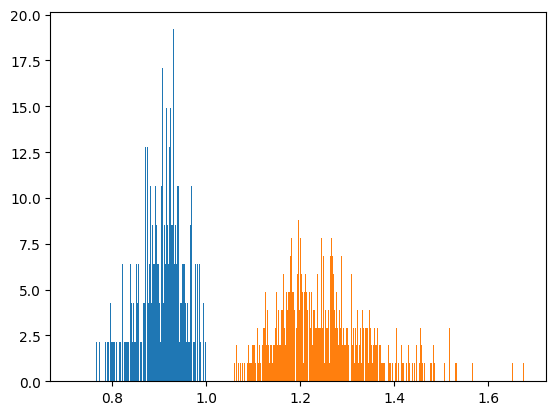

In [7]:
#vec = np.load(f'wpca_vec_white_noise_id_{id}_l_{l}.npy')
#ev = np.load(f'wpca_ev_white_noise_id_{id}_l_{l}.npy')

plt_a13_list = []
plt_a32_list = []

for mm in range(len(wpca_ev_list)):
    plt_a13_list.append(wpca_ev_list[mm][0]/wpca_ev_list[mm][2])
    plt_a32_list.append(wpca_ev_list[mm][2]/wpca_ev_list[mm][1])


plt.hist(plt_a32_list, density = True, bins= 301);
plt.hist(plt_a13_list, density = True, bins= 301);


In [ ]:
import glob

npy_files = glob.glob('*ev.npy')

print(npy_files)

['wpca_white_noise_id_32139_l_5_ev.npy']
